# Demand Forecasting of Wheat Production (in Tons)

**Country:** Argentina  
**Data Source:** FAOSTAT  

## Objective
To forecast soybean oil production using statistical and machine learning
models by ensuring stationarity, enhancing features, and improving forecast accuracy.


## Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pmdarima as pm

import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')


## Load Dataset


In [2]:
df = pd.read_csv("FAOSTAT_wheat.csv")   # change file if needed

df.head()


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,32,Argentina,5510,Production,111,Wheat,1961,1961,t,5725000,A,Official figure,NaN
1,QCL,Crops and livestock products,32,Argentina,5510,Production,111,Wheat,1962,1962,t,5700000,A,Official figure,NaN
2,QCL,Crops and livestock products,32,Argentina,5510,Production,111,Wheat,1963,1963,t,8940000,A,Official figure,NaN
3,QCL,Crops and livestock products,32,Argentina,5510,Production,111,Wheat,1964,1964,t,11260000,A,Official figure,NaN
4,QCL,Crops and livestock products,32,Argentina,5510,Production,111,Wheat,1965,1965,t,6079000,A,Official figure,NaN


## Data Preprocessing


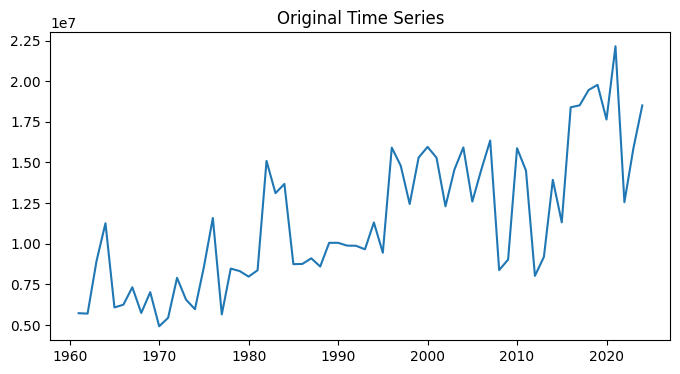

In [3]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

ts = df['Value']
ts = ts.sort_index()

plt.figure(figsize=(8,4))
plt.plot(ts)
plt.title("Original Time Series")
plt.show()


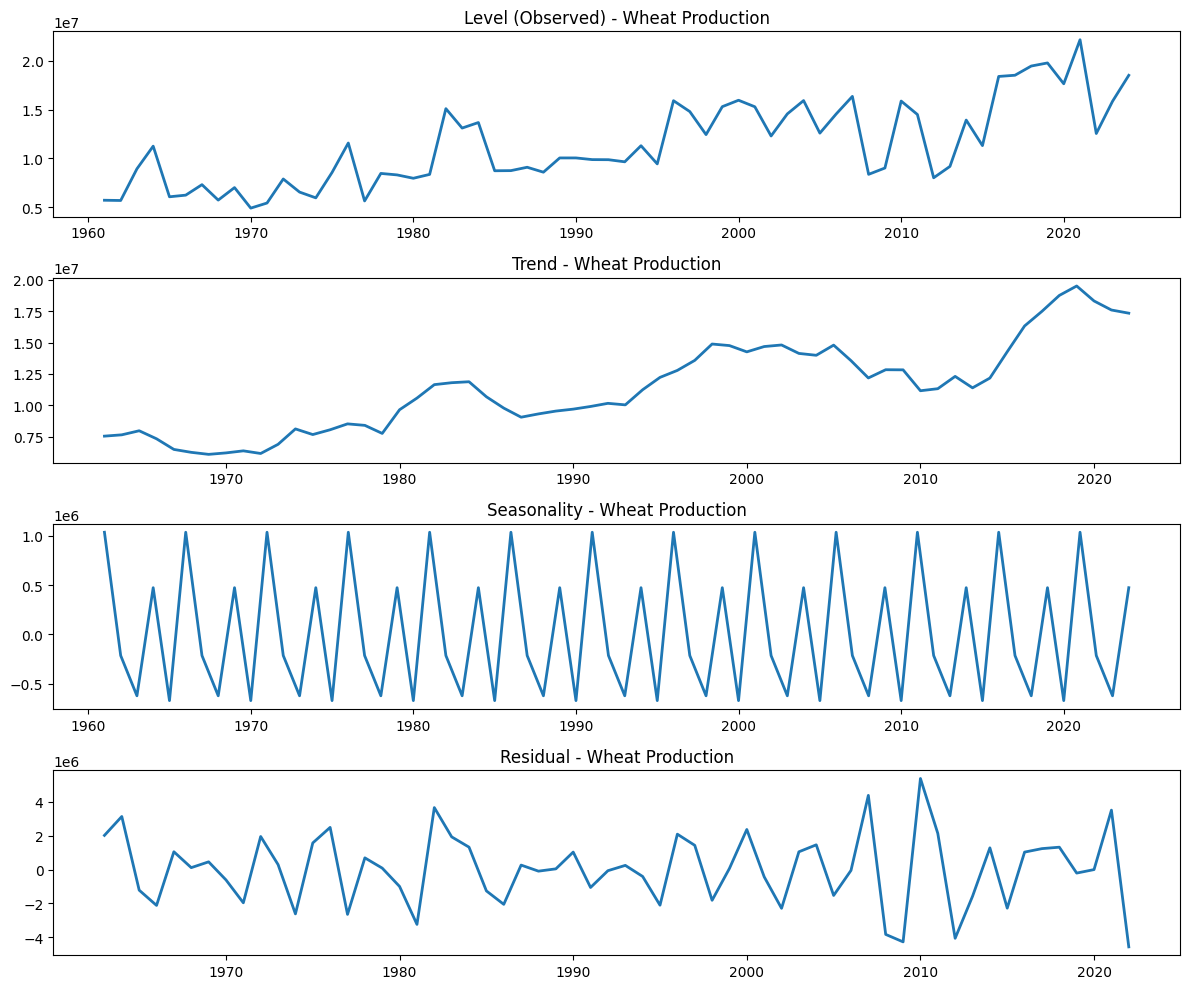

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Select time series
series = ts.dropna()

# Decomposition
decomposition = seasonal_decompose(series, model='additive', period=5)

# Plot components
plt.figure(figsize=(12,10))

plt.subplot(4,1,1)
plt.plot(decomposition.observed, linewidth=2)
plt.title("Level (Observed) - Wheat Production")

plt.subplot(4,1,2)
plt.plot(decomposition.trend, linewidth=2)
plt.title("Trend - Wheat Production")

plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, linewidth=2)
plt.title("Seasonality - Wheat Production")

plt.subplot(4,1,4)
plt.plot(decomposition.resid, linewidth=2)
plt.title("Residual - Wheat Production")

plt.tight_layout()
plt.show()


## Log Transformation


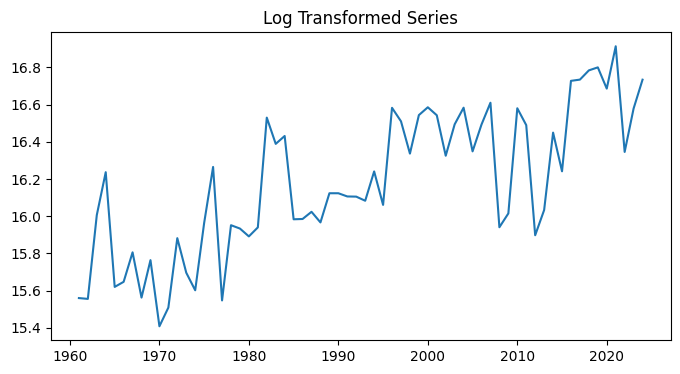

In [12]:
ts_log = np.log(ts)

plt.figure(figsize=(8,4))
plt.plot(ts_log)
plt.title("Log Transformed Series")
plt.show()


## First Order Differencing


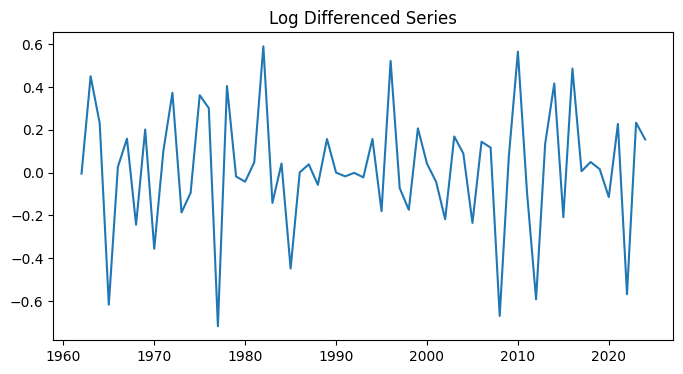

In [13]:
ts_log_diff = ts_log.diff().dropna()

plt.figure(figsize=(8,4))
plt.plot(ts_log_diff)
plt.title("Log Differenced Series")
plt.show()


## Train Test Split


In [14]:
train = ts_log_diff[:-5]
test = ts_log_diff[-5:]


## ARIMA Model


In [15]:
arima_model = ARIMA(train, order=(1,0,1))
arima_fit = arima_model.fit()

arima_forecast_diff = arima_fit.forecast(steps=5)

last_log = ts_log.iloc[-6]

arima_forecast_log = last_log + arima_forecast_diff.cumsum()
arima_forecast = np.exp(arima_forecast_log)

arima_rmse = np.sqrt(mean_squared_error(ts[-5:], arima_forecast))
arima_rmse


np.float64(3162257.9087466225)

## SARIMA Model


In [16]:
sarima_model = SARIMAX(
    train,
    order=(1,0,1),
    seasonal_order=(0,0,0,0),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)

sarima_forecast_diff = sarima_fit.forecast(steps=5)

sarima_forecast_log = last_log + sarima_forecast_diff.cumsum()
sarima_forecast = np.exp(sarima_forecast_log)

sarima_rmse = np.sqrt(mean_squared_error(ts[-5:], sarima_forecast))
sarima_rmse


np.float64(3148573.885998396)

## Auto ARIMA Model


In [17]:
auto_model = pm.auto_arima(ts_log, seasonal=False, stepwise=True, trace=True)

auto_forecast_log = auto_model.predict(n_periods=5)
auto_forecast = np.exp(auto_forecast_log)

auto_rmse = np.sqrt(mean_squared_error(ts[-5:], auto_forecast))
auto_rmse


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25.836, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.795, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10.698, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24.099, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10.820, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.707 seconds


np.float64(3447191.811254725)

## Random Forest Model


In [18]:
df_rf = pd.DataFrame(ts_log_diff)
df_rf.columns = ['value']

df_rf['lag1'] = df_rf['value'].shift(1)
df_rf['lag2'] = df_rf['value'].shift(2)
df_rf.dropna(inplace=True)

X = df_rf[['lag1','lag2']]
y = df_rf['value']

X_train, X_test = X[:-5], X[-5:]
y_train, y_test = y[:-5], y[-5:]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_forecast_diff = rf.predict(X_test)

rf_forecast_log = last_log + pd.Series(rf_forecast_diff).cumsum()
rf_forecast = np.exp(rf_forecast_log)

rf_rmse = np.sqrt(mean_squared_error(ts[-5:], rf_forecast))
rf_rmse


np.float64(7115624.347273546)

## Model Comparison


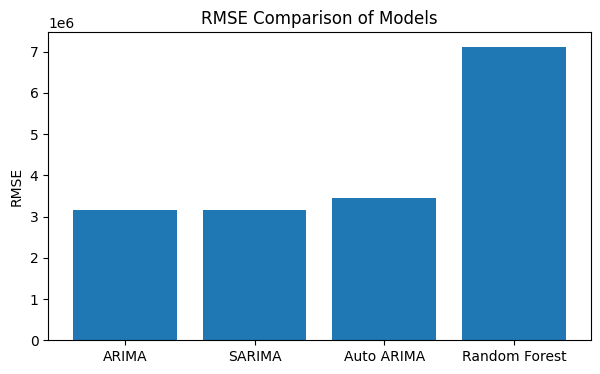

In [19]:
models = ['ARIMA', 'SARIMA', 'Auto ARIMA', 'Random Forest']
rmse_values = [arima_rmse, sarima_rmse, auto_rmse, rf_rmse]

plt.figure(figsize=(7,4))
plt.bar(models, rmse_values)
plt.ylabel("RMSE")
plt.title("RMSE Comparison of Models")
plt.show()


## Best Model Selection


In [20]:
best_model = models[np.argmin(rmse_values)]
best_model


'SARIMA'

## Final Forecast


In [21]:
n_periods = 5

future_years = pd.date_range(
    ts.index[-1] + pd.DateOffset(years=1),
    periods=n_periods,
    freq='Y'
)

final_forecast_diff = sarima_fit.forecast(steps=n_periods)
final_forecast_log = ts_log.iloc[-1] + final_forecast_diff.cumsum()
final_forecast = np.exp(final_forecast_log)

forecast_df = pd.DataFrame({
    "Year": future_years,
    "Forecasted Value": final_forecast
}).set_index("Year")

forecast_df


,Forecasted Value
Year,
2025-12-31,1.645287e+07
2026-12-31,1.601895e+07
2027-12-31,1.605531e+07
2028-12-31,1.624095e+07
2029-12-31,1.647707e+07


## Final Forecast Plot


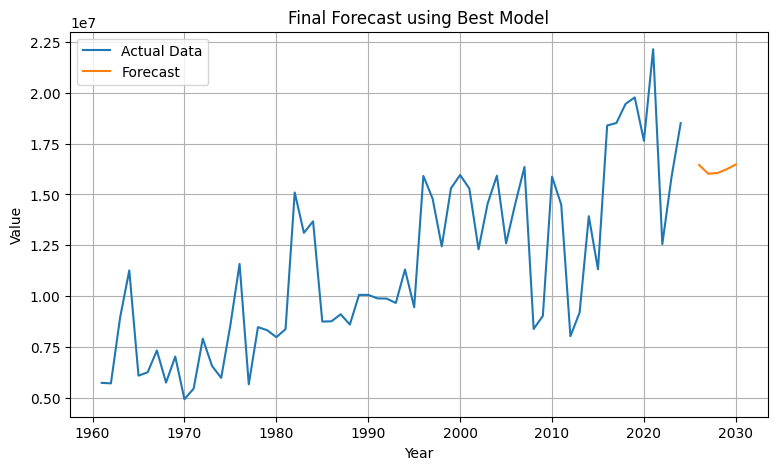

In [24]:
plt.figure(figsize=(9,5))
plt.plot(ts, label="Actual Data")

plt.plot(
    forecast_df.index,
    forecast_df["Forecasted Value"],
    # marker='o',
    linestyle='-', 
    label="Forecast"
)

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Final Forecast using Best Model")
plt.legend()
plt.grid()
plt.show()
